In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

### Dataset

In [3]:
class DepressionDataset(Dataset):
    def __init__(self, df, cat_cols, num_cols, target_col):
        # Ensure target column is treated as categorical and encoded
        all_cat_cols = cat_cols + [target_col] # Include target in categorical processing

        # label encoding categorical
        self.cat_maps = {}
        for c in all_cat_cols: # Iterate through all categorical columns including target
            le = LabelEncoder()
            # Handle potential NaN values by converting to string
            df[c] = le.fit_transform(df[c].astype(str))
            self.cat_maps[c] = le

        # standardize numerical
        scaler = StandardScaler()
        # Apply scaling only to the specified numerical columns
        df[num_cols] = scaler.fit_transform(df[num_cols])

        # Separate features and target after encoding/scaling
        # Remove target column from the features for the model input
        feature_cat_cols = [c for c in all_cat_cols if c != target_col]

        self.X_cat = torch.LongTensor(df[feature_cat_cols].values)
        self.X_num = torch.FloatTensor(df[num_cols].values)
        # The target column is now encoded and can be converted to LongTensor
        self.y     = torch.LongTensor(df[target_col].values)

    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        return self.X_cat[i], self.X_num[i], self.y[i]

### Model

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim: int, num_heads: int):
        super().__init__()
        assert input_dim % num_heads == 0
        self.num_heads = num_heads
        self.dim_per_head = input_dim // num_heads
        self.q_linear = nn.Linear(input_dim, input_dim)
        self.k_linear = nn.Linear(input_dim, input_dim)
        self.v_linear = nn.Linear(input_dim, input_dim)
        self.out = nn.Linear(input_dim, input_dim)

    def forward(self, Q, K, V, mask=None):
        B, L, C = Q.shape
        # linear + split heads
        Q = self.q_linear(Q).view(B, L, self.num_heads, self.dim_per_head).permute(0,2,1,3)
        K = self.k_linear(K).view(B, L, self.num_heads, self.dim_per_head).permute(0,2,1,3)
        V = self.v_linear(V).view(B, L, self.num_heads, self.dim_per_head).permute(0,2,1,3)
        # scaled dot‐prod
        scores = (Q @ K.transpose(-2,-1)) / (self.dim_per_head**0.5)  # [B, h, L, L]
        if mask is not None:
            scores = scores.masked_fill(mask==0, -1e9)
        weights = torch.softmax(scores, dim=-1)
        attn = (weights @ V)               # [B,h,L,dh]
        attn = attn.permute(0,2,1,3).contiguous().view(B, L, C)
        return self.out(attn)

class FeedForwardNetwork(nn.Module):
    def __init__(self, input_dim: int, ff_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, input_dim)
        )
    def forward(self, x):
        return self.net(x)

class TransformerEncoderCell(nn.Module):
    def __init__(self, dim, heads, ff_dim, dropout):
        super().__init__()
        self.attn = MultiHeadAttention(dim, heads)
        self.norm1 = nn.LayerNorm(dim)
        self.drop1 = nn.Dropout(dropout)
        self.ff   = FeedForwardNetwork(dim, ff_dim)
        self.norm2 = nn.LayerNorm(dim)
        self.drop2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        y = self.norm1(x + self.drop1(self.attn(x,x,x,mask)))
        y = self.norm2(y + self.drop2(self.ff(y)))
        return y

class TransformerEncoder(nn.Module):
    def __init__(self, dim, heads, ff_dim, depth, dropout):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderCell(dim, heads, ff_dim, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class PositionalEncoding(nn.Module):
    def __init__(self, dim, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, dim)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        inv = torch.pow(10000, -torch.arange(0, dim, 2).float() / dim)
        pe[:, 0::2] = torch.sin(pos * inv)
        pe[:, 1::2] = torch.cos(pos * inv)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x: [B, L, C]
        return x + self.pe[:, :x.size(1)]

In [5]:
class TabTransformer(nn.Module):
    def __init__(self, cat_dims, num_dim, embed_dim=32,
                 heads=4, depth=2, ff_dim=64, dropout=0.1):
        super().__init__()
        # categorical embedding
        self.cat_embs = nn.ModuleList([
            nn.Embedding(dim, embed_dim) for dim in cat_dims
        ])
        # numerical feature mapping → embedding
        self.num_lin = nn.Linear(num_dim, embed_dim)
        # positional + transformer
        self.pos_enc = PositionalEncoding(embed_dim, max_len=len(cat_dims)+1)
        self.transf  = TransformerEncoder(embed_dim, heads, ff_dim, depth, dropout)
        # classification head
        self.head = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 2)
        )

    def forward(self, x_cat, x_num):
        # x_cat: [B, C], x_num: [B, N]
        emb_cat = [emb(x_cat[:,i]) for i,emb in enumerate(self.cat_embs)]
        emb_num = self.num_lin(x_num).unsqueeze(1)           # [B,1,embed]
        seq = torch.stack(emb_cat, dim=1)                    # [B, C, E]
        seq = torch.cat([seq, emb_num], dim=1)               # [B, C+1, E]
        seq = self.pos_enc(seq)
        seq = self.transf(seq)                               # [B, C+1, E]
        feat = seq.mean(dim=1)                               # [B, E]
        return self.head(feat)

### Train

In [6]:
def train_epoch(model, loader, opt, criterion, device):
    model.train()
    total, correct = 0, 0
    for xc, xn, y in loader:
        xc,xn,y = xc.to(device), xn.to(device), y.to(device)
        opt.zero_grad()
        pred = model(xc, xn)
        loss = criterion(pred, y)
        loss.backward()
        opt.step()
        total += y.size(0)
        correct += (pred.argmax(1)==y).sum().item()
    return loss.item(), correct/total

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total, correct = 0, 0
    y_true = []
    y_pred = []
    y_score = []
    with torch.no_grad():
        for xc, xn, y in loader:
            xc,xn,y = xc.to(device), xn.to(device), y.to(device)
            # pred = model(xc, xn)
            # loss = criterion(pred, y)
            # total += y.size(0)
            # correct += (pred.argmax(1)==y).sum().item()
            logits = model(xc, xn)
            loss = criterion(logits, y)
            probs = torch.softmax(logits, dim=1)[:, 1]         # Get probabilities for the positive class
            preds = logits.argmax(dim=1)
            
            total += y.size(0)
            correct += (preds == y).sum().item()
            
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_score.extend(probs.cpu().numpy())
    
    precision   = precision_score(y_true, y_pred)
    recall      = recall_score(y_true, y_pred)
    f1          = f1_score(y_true, y_pred)
    auc         = roc_auc_score(y_true, y_score)
    # confusion = TN / (TN + FP)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    accuracy    = correct / total
    # return loss.item(), correct/total
    return {
        'loss': loss.item(),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'auc': auc
    }

In [7]:
def load_and_preprocess(df, cat_cols, num_cols, target):
    df[cat_cols] = df[cat_cols].fillna('Missing')
    
    for n in num_cols:
        df[f"{n}_missing"] = df[n].isna().astype(int)
        df[n] = df[n].fillna(df[n].mean())
    
    return df

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("final_depression_dataset_1.csv")
# print(df.isna().sum())
target = "Depression"
cat_cols = [c for c in df.columns if df[c].dtype == "object" and c!=target]
num_cols = [c for c in df.columns if c not in cat_cols+[target]]

df = load_and_preprocess(df, cat_cols, num_cols, target)
# Pass the original df and column lists to the dataset
ds = DepressionDataset(df.copy(), cat_cols, num_cols, target) # Use a copy to avoid modifying the original df outside the class if needed later

train_ds, val_ds = train_test_split(ds, test_size=0.2, stratify=ds.y, random_state=42)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=64, shuffle=False)

model = TabTransformer(
    # cat_dims should be based on the actual categorical feature columns, excluding the target
    cat_dims=[len(ds.cat_maps[c].classes_) for c in cat_cols],
    num_dim=len(num_cols),
    embed_dim=32, heads=4, depth=2, ff_dim=64, dropout=0.1
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

best_acc = 0
for epoch in range(1, 31):
    loss_tr, acc_tr = train_epoch(model, train_dl, optimizer, criterion, device)
    # loss_va, acc_va = eval_epoch(model, val_dl,   criterion, device)
    metrics = eval_epoch(model, val_dl, criterion, device)

    # print(f"Epoch {epoch:02d} | "
    #         f"train: loss={loss_tr:.4f}, acc={acc_tr:.4f} | "
    #         f"val:   loss={loss_va:.4f}, acc={acc_va:.4f}")
    print(f"Epoch {epoch:02d} | "
          f"train loss={loss_tr:.4f}, acc={acc_tr:.4f} | "
          f"val  loss={metrics['loss']:.4f}, acc={metrics['accuracy']:.4f}, "
          f"prec={metrics['precision']:.4f}, rec={metrics['recall']:.4f}, "
          f"spec={metrics['specificity']:.4f}, f1={metrics['f1']:.4f}, auc={metrics['auc']:.4f}")


    if metrics['accuracy'] > best_acc:
        best_acc = metrics['accuracy']
        torch.save(model.state_dict(), "best_tabtransformer.pt")
print("Best val accuracy:", best_acc)

/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 | train loss=0.5762, acc=0.8209 | val  loss=0.5024, acc=0.8223, prec=0.0000, rec=0.0000, spec=1.0000, f1=0.0000, auc=0.7028


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 | train loss=0.3952, acc=0.8219 | val  loss=0.4968, acc=0.8223, prec=0.0000, rec=0.0000, spec=1.0000, f1=0.0000, auc=0.8221


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 03 | train loss=0.5296, acc=0.8219 | val  loss=0.4705, acc=0.8223, prec=0.0000, rec=0.0000, spec=1.0000, f1=0.0000, auc=0.8623
Epoch 04 | train loss=0.2509, acc=0.8302 | val  loss=0.4571, acc=0.8711, prec=0.7660, rec=0.3956, spec=0.9739, f1=0.5217, auc=0.8813
Epoch 05 | train loss=0.2167, acc=0.8669 | val  loss=0.3981, acc=0.8867, prec=0.8235, rec=0.4615, spec=0.9786, f1=0.5915, auc=0.9089
Epoch 06 | train loss=0.2480, acc=0.8777 | val  loss=0.3621, acc=0.8867, prec=0.7324, rec=0.5714, spec=0.9549, f1=0.6420, auc=0.9262
Epoch 07 | train loss=0.3136, acc=0.8953 | val  loss=0.3184, acc=0.9102, prec=0.7586, rec=0.7253, spec=0.9501, f1=0.7416, auc=0.9541
Epoch 08 | train loss=0.1003, acc=0.9271 | val  loss=0.2390, acc=0.9473, prec=0.8478, rec=0.8571, spec=0.9667, f1=0.8525, auc=0.9797
Epoch 09 | train loss=0.0938, acc=0.9516 | val  loss=0.2064, acc=0.9551, prec=0.9595, rec=0.7802, spec=0.9929, f1=0.8606, auc=0.9872
Epoch 10 | train loss=0.1103, acc=0.9589 | val  loss=0.1580, acc=0.95


=== lr=0.0003, ff=64, em=32, d=2 ===


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 | train loss=0.6238 acc=0.8214 | val loss=0.5103 acc=0.8223


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 | train loss=0.3886 acc=0.8219 | val loss=0.4848 acc=0.8223


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 03 | train loss=0.5173 acc=0.8219 | val loss=0.4522 acc=0.8223
Epoch 04 | train loss=0.2787 acc=0.8273 | val loss=0.3907 acc=0.8438
Epoch 05 | train loss=0.3142 acc=0.8704 | val loss=0.3680 acc=0.8945
Epoch 06 | train loss=0.2122 acc=0.8929 | val loss=0.2984 acc=0.9121
Epoch 07 | train loss=0.1556 acc=0.9139 | val loss=0.2307 acc=0.9258
Epoch 08 | train loss=0.0619 acc=0.9452 | val loss=0.1474 acc=0.9453
Epoch 09 | train loss=0.0729 acc=0.9574 | val loss=0.1272 acc=0.9609
Epoch 10 | train loss=0.1084 acc=0.9667 | val loss=0.1404 acc=0.9570
Epoch 11 | train loss=0.0808 acc=0.9697 | val loss=0.1143 acc=0.9648
Epoch 12 | train loss=0.0524 acc=0.9746 | val loss=0.1064 acc=0.9648
Epoch 13 | train loss=0.0353 acc=0.9765 | val loss=0.0909 acc=0.9668
Epoch 14 | train loss=0.0098 acc=0.9795 | val loss=0.1030 acc=0.9668
Epoch 15 | train loss=0.0329 acc=0.9799 | val loss=0.1068 acc=0.9668
Epoch 16 | train loss=0.0212 acc=0.9780 | val loss=0.0976 acc=0.9727
Epoch 17 | train loss=0.1232 acc=0

/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 | train loss=0.6057 acc=0.7387 | val loss=0.5108 acc=0.8223


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 | train loss=0.4212 acc=0.8219 | val loss=0.5009 acc=0.8223


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 03 | train loss=0.5898 acc=0.8219 | val loss=0.4889 acc=0.8223


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 04 | train loss=0.3818 acc=0.8219 | val loss=0.4591 acc=0.8223
Epoch 05 | train loss=0.2528 acc=0.8459 | val loss=0.4266 acc=0.8848
Epoch 06 | train loss=0.2447 acc=0.8796 | val loss=0.3887 acc=0.8926
Epoch 07 | train loss=0.2487 acc=0.8787 | val loss=0.3619 acc=0.9062
Epoch 08 | train loss=0.1928 acc=0.8953 | val loss=0.3103 acc=0.9219
Epoch 09 | train loss=0.1621 acc=0.9217 | val loss=0.2146 acc=0.9531
Epoch 10 | train loss=0.1630 acc=0.9516 | val loss=0.1769 acc=0.9512
Epoch 11 | train loss=0.1223 acc=0.9599 | val loss=0.1765 acc=0.9414
Epoch 12 | train loss=0.0691 acc=0.9589 | val loss=0.1499 acc=0.9551
Epoch 13 | train loss=0.0652 acc=0.9721 | val loss=0.1399 acc=0.9629
Epoch 14 | train loss=0.1317 acc=0.9746 | val loss=0.1210 acc=0.9590
Epoch 15 | train loss=0.1972 acc=0.9799 | val loss=0.1266 acc=0.9688
Epoch 16 | train loss=0.0716 acc=0.9755 | val loss=0.1404 acc=0.9688
Epoch 17 | train loss=0.0455 acc=0.9750 | val loss=0.1067 acc=0.9629
Epoch 18 | train loss=0.0477 acc=0

/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 | train loss=0.5490 acc=0.7764 | val loss=0.5547 acc=0.8223


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 | train loss=0.4431 acc=0.8219 | val loss=0.4977 acc=0.8223


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 03 | train loss=0.3652 acc=0.8219 | val loss=0.4820 acc=0.8223


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 04 | train loss=0.4405 acc=0.8219 | val loss=0.4723 acc=0.8223


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 05 | train loss=0.4083 acc=0.8219 | val loss=0.4588 acc=0.8223


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 06 | train loss=0.4136 acc=0.8219 | val loss=0.4394 acc=0.8223
Epoch 07 | train loss=0.3761 acc=0.8219 | val loss=0.4133 acc=0.8262
Epoch 08 | train loss=0.2625 acc=0.8415 | val loss=0.3863 acc=0.8730
Epoch 09 | train loss=0.3036 acc=0.8669 | val loss=0.3662 acc=0.8809
Epoch 10 | train loss=0.2825 acc=0.8738 | val loss=0.3524 acc=0.8867
Epoch 11 | train loss=0.1544 acc=0.8801 | val loss=0.3396 acc=0.8867
Epoch 12 | train loss=0.3385 acc=0.8801 | val loss=0.3221 acc=0.8848
Epoch 13 | train loss=0.3301 acc=0.8826 | val loss=0.3113 acc=0.8887
Epoch 14 | train loss=0.2629 acc=0.8880 | val loss=0.2974 acc=0.8945
Epoch 15 | train loss=0.1527 acc=0.8958 | val loss=0.2714 acc=0.9004
Epoch 16 | train loss=0.2367 acc=0.8992 | val loss=0.2538 acc=0.9004
Epoch 17 | train loss=0.1596 acc=0.9012 | val loss=0.2155 acc=0.9102
Epoch 18 | train loss=0.1200 acc=0.9178 | val loss=0.1773 acc=0.9336
Epoch 19 | train loss=0.0905 acc=0.9320 | val loss=0.1492 acc=0.9434
Epoch 20 | train loss=0.1280 acc=0

/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 | train loss=0.4750 acc=0.7935 | val loss=0.5476 acc=0.8223


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 | train loss=0.5511 acc=0.8219 | val loss=0.5047 acc=0.8223


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 03 | train loss=0.4732 acc=0.8219 | val loss=0.4983 acc=0.8223


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 04 | train loss=0.3448 acc=0.8219 | val loss=0.4964 acc=0.8223


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 05 | train loss=0.3820 acc=0.8219 | val loss=0.4940 acc=0.8223


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 06 | train loss=0.4857 acc=0.8219 | val loss=0.4908 acc=0.8223


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 07 | train loss=0.4254 acc=0.8219 | val loss=0.4864 acc=0.8223


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 08 | train loss=0.3760 acc=0.8219 | val loss=0.4807 acc=0.8223


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 09 | train loss=0.3653 acc=0.8219 | val loss=0.4710 acc=0.8223


/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10 | train loss=0.4048 acc=0.8219 | val loss=0.4557 acc=0.8223
Epoch 11 | train loss=0.3979 acc=0.8234 | val loss=0.4380 acc=0.8340
Epoch 12 | train loss=0.3478 acc=0.8474 | val loss=0.4272 acc=0.8691
Epoch 13 | train loss=0.3329 acc=0.8684 | val loss=0.4189 acc=0.8789
Epoch 14 | train loss=0.2309 acc=0.8743 | val loss=0.4088 acc=0.8887
Epoch 15 | train loss=0.3180 acc=0.8801 | val loss=0.3847 acc=0.8945
Epoch 16 | train loss=0.2111 acc=0.8811 | val loss=0.3631 acc=0.8945
Epoch 17 | train loss=0.3664 acc=0.8865 | val loss=0.3432 acc=0.8945
Epoch 18 | train loss=0.2576 acc=0.8963 | val loss=0.3004 acc=0.9160
Epoch 19 | train loss=0.2069 acc=0.9119 | val loss=0.2635 acc=0.9238
Epoch 20 | train loss=0.1536 acc=0.9349 | val loss=0.2291 acc=0.9355
Epoch 21 | train loss=0.0954 acc=0.9501 | val loss=0.2037 acc=0.9375
Epoch 22 | train loss=0.1422 acc=0.9486 | val loss=0.1864 acc=0.9434
Epoch 23 | train loss=0.0765 acc=0.9569 | val loss=0.1753 acc=0.9492
Epoch 24 | train loss=0.0694 acc=0

/Users/zhijie/opt/anaconda3/envs/aisafety/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 | train loss=0.5018 acc=0.8156 | val loss=0.4743 acc=0.8223
Epoch 02 | train loss=0.3075 acc=0.8366 | val loss=0.4314 acc=0.8906
Epoch 03 | train loss=0.2800 acc=0.8777 | val loss=0.3653 acc=0.9023
Epoch 04 | train loss=0.4252 acc=0.9007 | val loss=0.3043 acc=0.9277
Epoch 05 | train loss=0.0980 acc=0.9447 | val loss=0.1970 acc=0.9629
Epoch 06 | train loss=0.2638 acc=0.9648 | val loss=0.1625 acc=0.9375
Epoch 07 | train loss=0.0144 acc=0.9662 | val loss=0.1522 acc=0.9727
Epoch 08 | train loss=0.2159 acc=0.9706 | val loss=0.1184 acc=0.9707
Epoch 09 | train loss=0.0587 acc=0.9721 | val loss=0.0817 acc=0.9785
Epoch 10 | train loss=0.0734 acc=0.9887 | val loss=0.0919 acc=0.9727
Epoch 11 | train loss=0.0353 acc=0.9853 | val loss=0.0642 acc=0.9707
Epoch 12 | train loss=0.0269 acc=0.9902 | val loss=0.0847 acc=0.9746
Epoch 13 | train loss=0.0098 acc=0.9843 | val loss=0.0908 acc=0.9688
Epoch 14 | train loss=0.0223 acc=0.9873 | val loss=0.0898 acc=0.9922
Epoch 15 | train loss=0.0042 acc=0

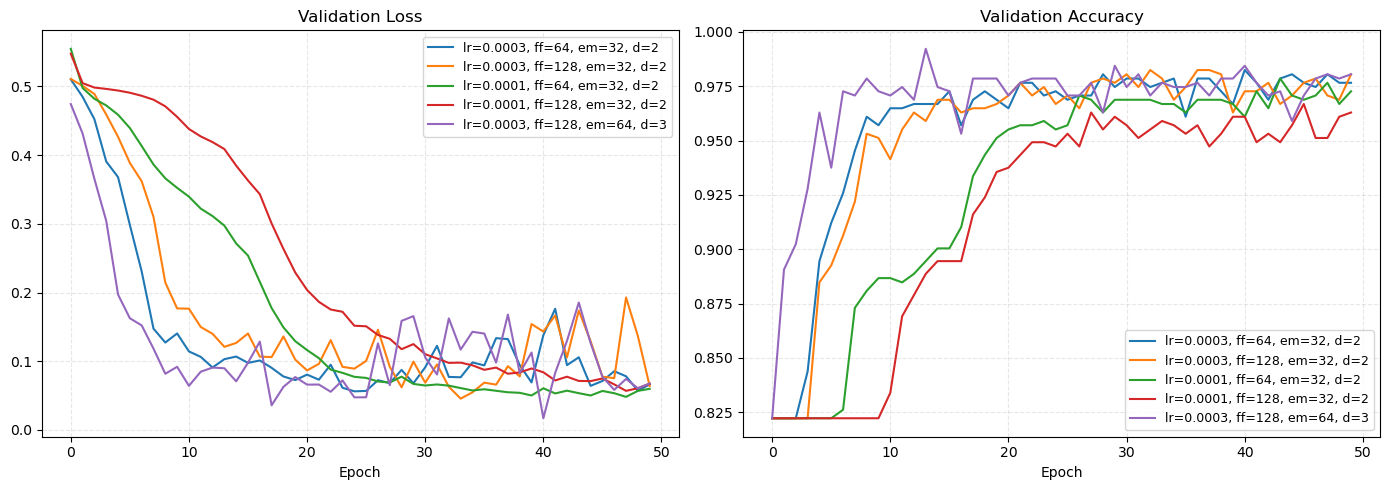

In [14]:
import matplotlib.pyplot as plt
from collections import defaultdict

hp_grid = [
    # lr,  ff_dim, embed, depth, dropout
    dict(lr=3e-4, ff_dim=64,  embed=32, depth=2, dropout=0.10),
    dict(lr=3e-4, ff_dim=128, embed=32, depth=2, dropout=0.10),
    dict(lr=1e-4, ff_dim=64,  embed=32, depth=2, dropout=0.10),
    dict(lr=1e-4, ff_dim=128, embed=32, depth=2, dropout=0.10),

    dict(lr=3e-4, ff_dim=128, embed=64, depth=3, dropout=0.15),
]

train_curves, val_curves, acc_curves = defaultdict(list), defaultdict(list), defaultdict(list)

epochs, patience = 50, 100
for cfg in hp_grid:
    tag = f'lr={cfg["lr"]:g}, ff={cfg["ff_dim"]}, em={cfg["embed"]}, d={cfg["depth"]}'
    print(f"\n=== {tag} ===")
    
    model = TabTransformer(
        cat_dims=[len(ds.cat_maps[c].classes_) for c in cat_cols],
        num_dim=len(num_cols),
        embed_dim=cfg["embed"],
        heads=4,
        depth=cfg["depth"],
        ff_dim=cfg["ff_dim"],
        dropout=cfg["dropout"]
    ).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=cfg["lr"], weight_decay=1e-4)
    criterion  = nn.CrossEntropyLoss()
    
    best_val, wait = 0, 0
    for epoch in range(1, epochs + 1):
        loss_tr, acc_tr = train_epoch(model, train_dl, optimizer, criterion, device)
        metrics = eval_epoch(model,  val_dl,   criterion, device)
        
        train_curves[tag].append(loss_tr)
        val_curves[tag].append(metrics['loss'])
        acc_curves[tag].append(metrics['accuracy'])

        print(f"Epoch {epoch:02d} | "
              f"train loss={loss_tr:.4f} acc={acc_tr:.4f} | "
              f"val loss={metrics['loss']:.4f} acc={metrics['accuracy']:.4f}")

        # Early-Stopping
        if metrics['accuracy'] > best_val + 1e-4:
            best_val, wait = metrics['accuracy'], 0
        else:
            wait += 1
        if wait >= patience:
            print(f"→ early stop @ {epoch}")
            break

# -Loss
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))
ax1.set_title("Validation Loss"); ax2.set_title("Validation Accuracy")
for tag in val_curves:
    ax1.plot(val_curves[tag], label=tag)
    ax2.plot(acc_curves[tag], label=tag)
for ax in (ax1, ax2):
    ax.set_xlabel("Epoch"); ax.grid(alpha=.3, ls="--"); ax.legend(fontsize=9)
plt.tight_layout(); plt.show()
